# EDSA 2021: Sendy Logistics Challenge
Predict the estimated time of arrival (ETA) for motorbike deliveries in Nairobi

# Overview

### - Introduction
### - Importing libraries and data
### - Exploratory Data Analysis
### - Data Cleaning and Formatting
### - Feature Engineering
### - Train/Test Split
### - Modeling
### - Making Predictions
### - Submission

# Introduction

In this notebook, based on historic data used to predict an accurate time for the arrival of the rider at the destination of a package, we will be building a machine learning model that predicts an accurate delivery time, from picking up a package to arriving at the final destination. An accurate arrival time prediction will help all businesses to improve their logistics and communicate an accurate time to their customers.

# Importing Python libraries

In [1]:
!pip install lightgbm

In [2]:
!pip install xgboost

In [18]:
#Linear algebra
import numpy as np

#Data processing
import pandas as pd

#Date library
import datetime as dt



#Data visualization
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.style as style
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

#Metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold, GridSearchCV 
from sklearn.model_selection import cross_val_score, learning_curve
from sklearn.metrics import mean_squared_error

#Algorithms
from sklearn.svm import SVR
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression

#import xgboost as xgb
import lightgbm as lgb

sns.set(style='white', context='notebook', palette='deep')

# Importing the dataset

In [19]:
#Train_Masked has extra columns: Delivery destination (day, month, time)
train_df = pd.read_csv('Train.csv') 
test_df = pd.read_csv('Test.csv') 
rider_df = pd.read_csv('Riders.csv') 
variable_df = pd.read_csv('VariableDefinitions.csv')

# Exploritory Data Analysis

## Understanding the train and test datasets

In [20]:
train_df.head()

,Order No,User Id,Vehicle Type,Platform Type,Personal or Business,Placement - Day of Month,Placement - Weekday (Mo = 1),Placement - Time,Confirmation - Day of Month,Confirmation - Weekday (Mo = 1),...,Arrival at Destination - Time,Distance (KM),Temperature,Precipitation in millimeters,Pickup Lat,Pickup Long,Destination Lat,Destination Long,Rider Id,Time from Pickup to Arrival
0,Order_No_4211,User_Id_633,Bike,3,Business,9,5,9:35:46 AM,9,5,...,10:39:55 AM,4,20.4,NaN,-1.317755,36.830370,-1.300406,36.829741,Rider_Id_432,745
1,Order_No_25375,User_Id_2285,Bike,3,Personal,12,5,11:16:16 AM,12,5,...,12:17:22 PM,16,26.4,NaN,-1.351453,36.899315,-1.295004,36.814358,Rider_Id_856,1993
2,Order_No_1899,User_Id_265,Bike,3,Business,30,2,12:39:25 PM,30,2,...,1:00:38 PM,3,NaN,NaN,-1.308284,36.843419,-1.300921,36.828195,Rider_Id_155,455
3,Order_No_9336,User_Id_1402,Bike,3,Business,15,5,9:25:34 AM,15,5,...,10:05:27 AM,9,19.2,NaN,-1.281301,36.832396,-1.257147,36.795063,Rider_Id_855,1341
4,Order_No_27883,User_Id_1737,Bike,1,Personal,13,1,9:55:18 AM,13,1,...,10:25:37 AM,9,15.4,NaN,-1.266597,36.792118,-1.295041,36.809817,Rider_Id_770,1214


In [159]:
test_df.head()

,Order No,User Id,Vehicle Type,Platform Type,Personal or Business,Placement - Day of Month,Placement - Weekday (Mo = 1),Placement - Time,Confirmation - Day of Month,Confirmation - Weekday (Mo = 1),...,Pickup - Time,Distance (KM),Temperature,Precipitation in millimeters,Pickup Lat,Pickup Long,Destination Lat,Destination Long,Rider Id,Time from Pickup to Arrival
0,Order_No_19248,User_Id_3355,Bike,3,Business,27,3,4:44:10 PM,27,3,...,5:06:47 PM,8,NaN,NaN,-1.333275,36.870815,-1.305249,36.822390,Rider_Id_192,NaN
1,Order_No_12736,User_Id_3647,Bike,3,Business,17,5,12:57:35 PM,17,5,...,1:25:37 PM,5,NaN,NaN,-1.272639,36.794723,-1.277007,36.823907,Rider_Id_868,NaN
2,Order_No_768,User_Id_2154,Bike,3,Business,27,4,11:08:14 AM,27,4,...,11:57:54 AM,5,22.8,NaN,-1.290894,36.822971,-1.276574,36.851365,Rider_Id_26,NaN
3,Order_No_15332,User_Id_2910,Bike,3,Business,17,1,1:51:35 PM,17,1,...,2:16:52 PM,5,24.5,NaN,-1.290503,36.809646,-1.303382,36.790658,Rider_Id_685,NaN
4,Order_No_21373,User_Id_1205,Bike,3,Business,11,2,11:30:28 AM,11,2,...,11:56:04 AM,6,24.4,NaN,-1.281081,36.814423,-1.266467,36.792161,Rider_Id_858,NaN


In [160]:
print(f'train: {train_df.shape} \n  test: {test_df.shape} \n riders: {rider_df.shape}')

train: (21201, 32) 
  test: (7068, 26) 
 riders: (960, 5)


There are 21 201, 7 068 and 960 data entries in the train, test and riders dataset respectevily.
Also, there are 29, 25 and 5 columns in the train, test and riders dataset respectevily. 

In [161]:
train_df.columns

Index(['Order No', 'User Id', 'Vehicle Type', 'Platform Type',
       'Personal or Business', 'Placement - Day of Month',
       'Placement - Weekday (Mo = 1)', 'Placement - Time',
       'Confirmation - Day of Month', 'Confirmation - Weekday (Mo = 1)',
       'Confirmation - Time', 'Arrival at Pickup - Day of Month',
       'Arrival at Pickup - Weekday (Mo = 1)', 'Arrival at Pickup - Time',
       'Pickup - Day of Month', 'Pickup - Weekday (Mo = 1)', 'Pickup - Time',
       'Distance (KM)', 'Temperature', 'Precipitation in millimeters',
       'Pickup Lat', 'Pickup Long', 'Destination Lat', 'Destination Long',
       'Rider Id', 'Time from Pickup to Arrival', 'Pickup_Hour',
       'Pickup_Minutes', 'Arrival_Destination_Hour',
       'Arrival_Destination_Minutes', 'Time from Pickup to Arrival_Hour',
       'Time from Pickup to Arrival_Minutes'],
      dtype='object')

In [22]:
test_df.columns

Index(['Order No', 'User Id', 'Vehicle Type', 'Platform Type',
       'Personal or Business', 'Placement - Day of Month',
       'Placement - Weekday (Mo = 1)', 'Placement - Time',
       'Confirmation - Day of Month', 'Confirmation - Weekday (Mo = 1)',
       'Confirmation - Time', 'Arrival at Pickup - Day of Month',
       'Arrival at Pickup - Weekday (Mo = 1)', 'Arrival at Pickup - Time',
       'Pickup - Day of Month', 'Pickup - Weekday (Mo = 1)', 'Pickup - Time',
       'Distance (KM)', 'Temperature', 'Precipitation in millimeters',
       'Pickup Lat', 'Pickup Long', 'Destination Lat', 'Destination Long',
       'Rider Id'],
      dtype='object')

In [23]:
for col in train_df.columns:
    if col not in test_df.columns:
        print(col)

Arrival at Destination - Day of Month
Arrival at Destination - Weekday (Mo = 1)
Arrival at Destination - Time
Time from Pickup to Arrival


There are four data columns in the train dataset that are not in the test dataset 

* Arrival at Destination - Day of Month
* Arrival at Destination - Weekday (Mo = 1)
* Arrival at Destination - Time
* Time from Pickup to Arrival

In [24]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21201 entries, 0 to 21200
Data columns (total 29 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Order No                                   21201 non-null  object 
 1   User Id                                    21201 non-null  object 
 2   Vehicle Type                               21201 non-null  object 
 3   Platform Type                              21201 non-null  int64  
 4   Personal or Business                       21201 non-null  object 
 5   Placement - Day of Month                   21201 non-null  int64  
 6   Placement - Weekday (Mo = 1)               21201 non-null  int64  
 7   Placement - Time                           21201 non-null  object 
 8   Confirmation - Day of Month                21201 non-null  int64  
 9   Confirmation - Weekday (Mo = 1)            21201 non-null  int64  
 10  Confirmation - Time   

In [25]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7068 entries, 0 to 7067
Data columns (total 25 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Order No                              7068 non-null   object 
 1   User Id                               7068 non-null   object 
 2   Vehicle Type                          7068 non-null   object 
 3   Platform Type                         7068 non-null   int64  
 4   Personal or Business                  7068 non-null   object 
 5   Placement - Day of Month              7068 non-null   int64  
 6   Placement - Weekday (Mo = 1)          7068 non-null   int64  
 7   Placement - Time                      7068 non-null   object 
 8   Confirmation - Day of Month           7068 non-null   int64  
 9   Confirmation - Weekday (Mo = 1)       7068 non-null   int64  
 10  Confirmation - Time                   7068 non-null   object 
 11  Arrival at Pickup

In [26]:
train_df.isnull().sum()

Order No                                         0
User Id                                          0
Vehicle Type                                     0
Platform Type                                    0
Personal or Business                             0
Placement - Day of Month                         0
Placement - Weekday (Mo = 1)                     0
Placement - Time                                 0
Confirmation - Day of Month                      0
Confirmation - Weekday (Mo = 1)                  0
Confirmation - Time                              0
Arrival at Pickup - Day of Month                 0
Arrival at Pickup - Weekday (Mo = 1)             0
Arrival at Pickup - Time                         0
Pickup - Day of Month                            0
Pickup - Weekday (Mo = 1)                        0
Pickup - Time                                    0
Arrival at Destination - Day of Month            0
Arrival at Destination - Weekday (Mo = 1)        0
Arrival at Destination - Time  

In [27]:
test_df.isnull().sum()

Order No                                   0
User Id                                    0
Vehicle Type                               0
Platform Type                              0
Personal or Business                       0
Placement - Day of Month                   0
Placement - Weekday (Mo = 1)               0
Placement - Time                           0
Confirmation - Day of Month                0
Confirmation - Weekday (Mo = 1)            0
Confirmation - Time                        0
Arrival at Pickup - Day of Month           0
Arrival at Pickup - Weekday (Mo = 1)       0
Arrival at Pickup - Time                   0
Pickup - Day of Month                      0
Pickup - Weekday (Mo = 1)                  0
Pickup - Time                              0
Distance (KM)                              0
Temperature                             1437
Precipitation in millimeters            6869
Pickup Lat                                 0
Pickup Long                                0
Destinatio

In [76]:
def missing_values(df, threshold=0):
    """Returns the feature name and the % of  missing values as dataframe"""

    return pd.DataFrame(data= {col: (df[col].isnull().mean()) for col in df.columns if df[col].isnull().mean() > threshold}, 
             index=['% of Missing values']).T

In [77]:
missing_values(train_df)

,% of Missing values
Temperature,0.205934
Precipitation in millimeters,0.973963


The train dataset has "Temperature" and "Precipitation in millimeters" data columns with 20.59 % and 97.4 % of data missing.

In [78]:
missing_values(test_df)

,% of Missing values
Temperature,0.203311
Precipitation in millimeters,0.971845


The test dataset has "Temperature" and "Precipitation in millimeters" data columns with 20.33 % and 97.18% of data missing.

In [30]:
train_df.describe()

,Platform Type,Placement - Day of Month,Placement - Weekday (Mo = 1),Confirmation - Day of Month,Confirmation - Weekday (Mo = 1),Arrival at Pickup - Day of Month,Arrival at Pickup - Weekday (Mo = 1),Pickup - Day of Month,Pickup - Weekday (Mo = 1),Arrival at Destination - Day of Month,Arrival at Destination - Weekday (Mo = 1),Distance (KM),Temperature,Precipitation in millimeters,Pickup Lat,Pickup Long,Destination Lat,Destination Long,Time from Pickup to Arrival
count,21201.000000,21201.000000,21201.000000,21201.000000,21201.000000,21201.000000,21201.000000,21201.000000,21201.000000,21201.000000,21201.000000,21201.000000,16835.000000,552.000000,21201.000000,21201.000000,21201.000000,21201.000000,21201.000000
mean,2.752182,15.653696,3.240083,15.653837,3.240225,15.653837,3.240225,15.653837,3.240225,15.653837,3.240225,9.506533,23.258889,7.905797,-1.281470,36.811264,-1.282581,36.811220,1556.920947
std,0.625178,8.798916,1.567295,8.798886,1.567228,8.798886,1.567228,8.798886,1.567228,8.798886,1.567228,5.668963,3.615768,17.089971,0.030507,0.037473,0.034824,0.044721,987.270788
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,11.200000,0.100000,-1.438302,36.653621,-1.430298,36.606594,1.000000
25%,3.000000,8.000000,2.000000,8.000000,2.000000,8.000000,2.000000,8.000000,2.000000,8.000000,2.000000,5.000000,20.600000,1.075000,-1.300921,36.784605,-1.301201,36.785661,882.000000
50%,3.000000,15.000000,3.000000,15.000000,3.000000,15.000000,3.000000,15.000000,3.000000,15.000000,3.000000,8.000000,23.500000,2.900000,-1.279395,36.807040,-1.284382,36.808002,1369.000000
75%,3.000000,23.000000,5.000000,23.000000,5.000000,23.000000,5.000000,23.000000,5.000000,23.000000,5.000000,13.000000,26.000000,4.900000,-1.257147,36.829741,-1.261177,36.829477,2040.000000
max,4.000000,31.000000,7.000000,31.000000,7.000000,31.000000,7.000000,31.000000,7.000000,31.000000,7.000000,49.000000,32.100000,99.100000,-1.147170,36.991046,-1.030225,37.016779,7883.000000


In [31]:
test_df.describe()

,Platform Type,Placement - Day of Month,Placement - Weekday (Mo = 1),Confirmation - Day of Month,Confirmation - Weekday (Mo = 1),Arrival at Pickup - Day of Month,Arrival at Pickup - Weekday (Mo = 1),Pickup - Day of Month,Pickup - Weekday (Mo = 1),Distance (KM),Temperature,Precipitation in millimeters,Pickup Lat,Pickup Long,Destination Lat,Destination Long
count,7068.000000,7068.000000,7068.000000,7068.000000,7068.000000,7068.000000,7068.000000,7068.000000,7068.000000,7068.000000,5631.000000,199.000000,7068.000000,7068.000000,7068.000000,7068.000000
mean,2.752122,15.621817,3.249859,15.621817,3.249859,15.621817,3.249859,15.621817,3.249859,9.458970,23.246120,6.651759,-1.282043,36.811148,-1.282255,36.811326
std,0.624000,8.776650,1.580926,8.776650,1.580926,8.776650,1.580926,8.776650,1.580926,5.575689,3.591161,14.085439,0.030044,0.037962,0.034236,0.043507
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,13.200000,0.100000,-1.433512,36.653828,-1.422652,36.639195
25%,3.000000,8.000000,2.000000,8.000000,2.000000,8.000000,2.000000,8.000000,2.000000,5.000000,20.600000,1.100000,-1.301201,36.784605,-1.300921,36.786546
50%,3.000000,15.000000,3.000000,15.000000,3.000000,15.000000,3.000000,15.000000,3.000000,8.000000,23.400000,2.900000,-1.281301,36.807219,-1.283219,36.807927
75%,3.000000,23.000000,5.000000,23.000000,5.000000,23.000000,5.000000,23.000000,5.000000,13.000000,25.900000,4.950000,-1.257274,36.829716,-1.261256,36.828195
max,4.000000,31.000000,7.000000,31.000000,7.000000,31.000000,7.000000,31.000000,7.000000,47.000000,32.100000,99.100000,-1.148352,36.991046,-1.030225,37.018958


# Visualization

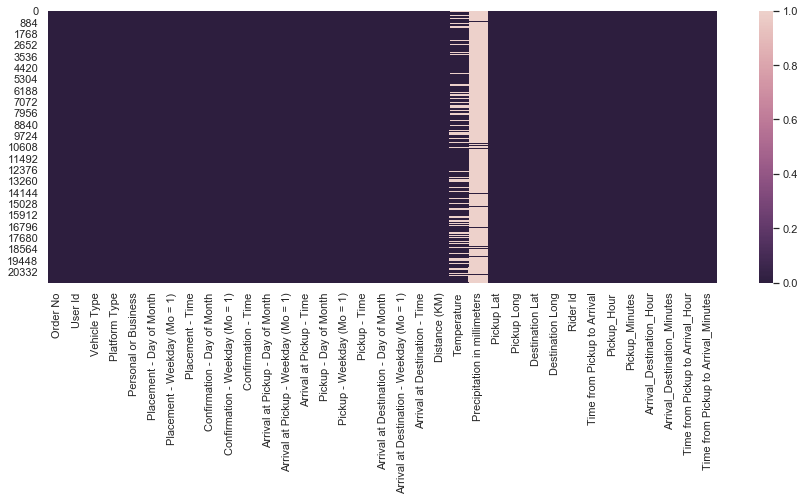

In [93]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(15, 5))
cmap = sns.cubehelix_palette(as_cmap=True, reverse=True)
sns.heatmap(train_df.isnull(), cmap=cmap)

Visuals from train dataset depicting data columns( "Temperature" and " precipitation in millimetrs") with missing values.

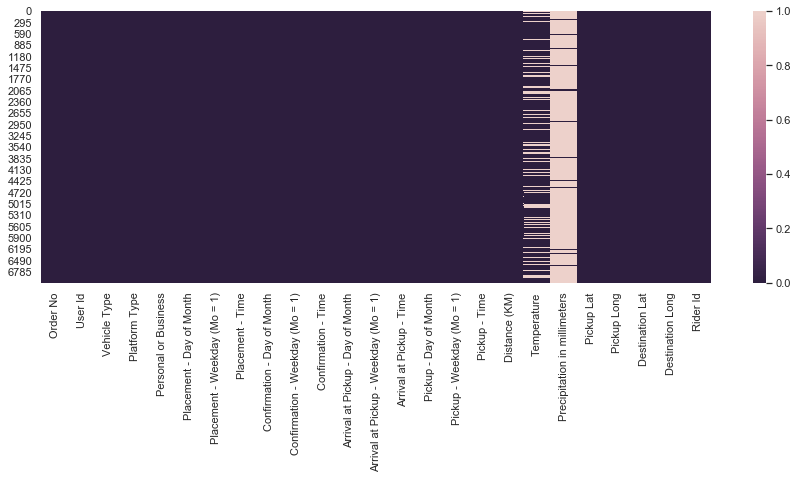

In [92]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(15, 5))
cmap = sns.cubehelix_palette(as_cmap=True, reverse=True)
sns.heatmap(test_df.isnull(), cmap=cmap)

Visuals from test dataset depicting data columns( "Temperature" and " precipitation in millimetrs") with missing values.

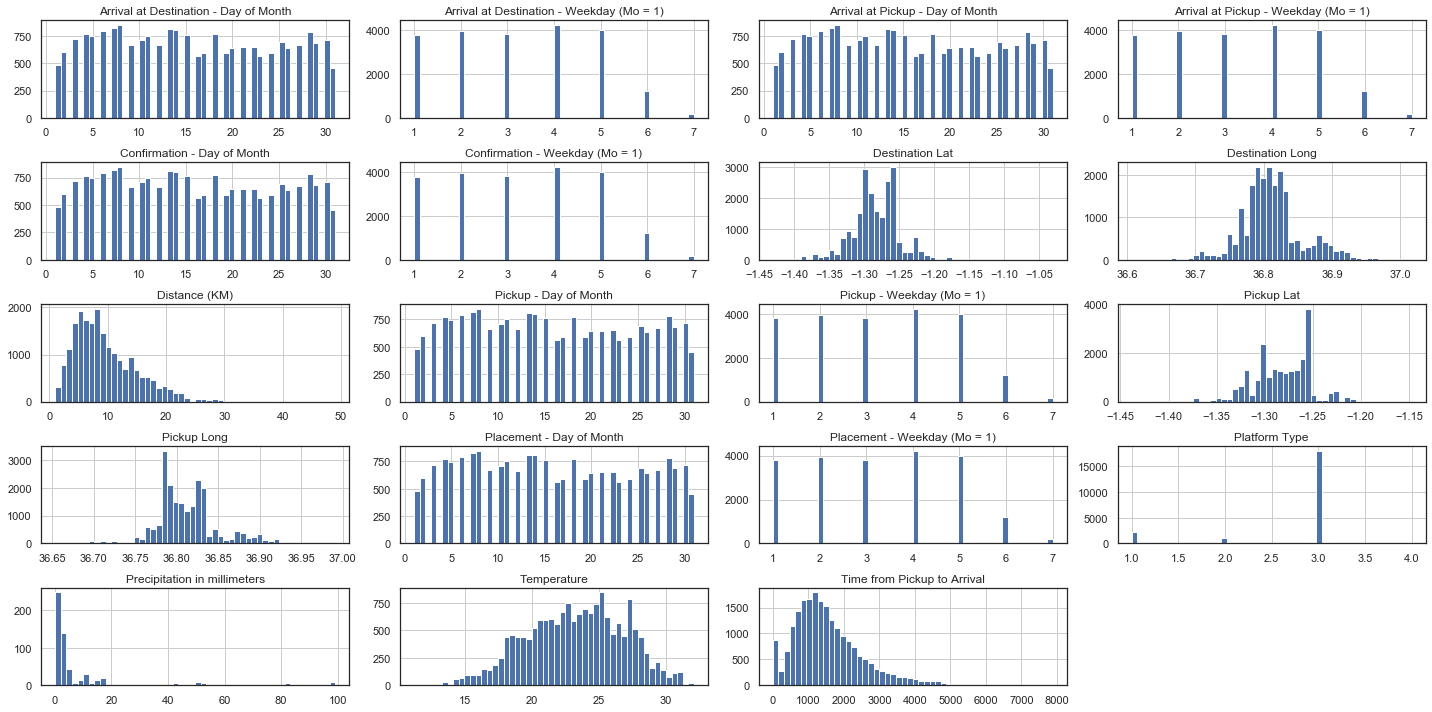

In [34]:
#Distribution review for train data
train_df[[column for column in train_df.select_dtypes(include='number')]].hist(bins=50, figsize=(20,10))
plt.tight_layout()
plt.show()

Deductions from the train dataset data column distribution.

* The most common temperature is 25 degrees Celsius.
* Platform 3 is the most used platform type
* Most of the orders delievered are from Business clients.
* Most orders are dealt with during the weekdays than on the weekend.
* Most of the trips covered between 8KM and 15KM.

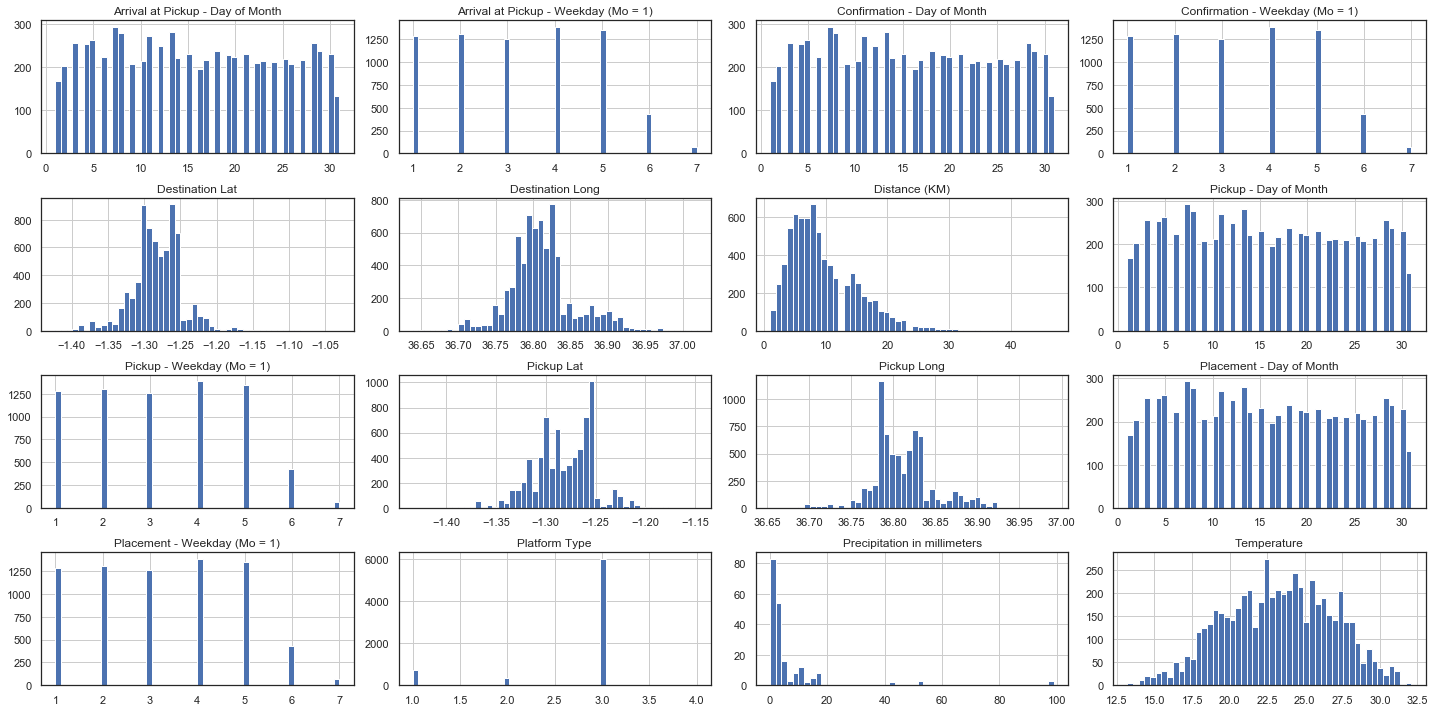

In [35]:
#Distribution review for test data
test_df[[column for column in test_df.select_dtypes(include='number')]].hist(bins=50, figsize=(20,10))
plt.tight_layout()
plt.show()

Deductions from the test dataset data column distribution.

* The most common temperature is 22,5 degrees Celsius.
* Platform 3 is the most used platform type
* Most of the orders delievered are from Business clients.
* Most orders are dealt with during the weekdays than on the weekend.
* Most of the trips covered between 4KM and 10KM.

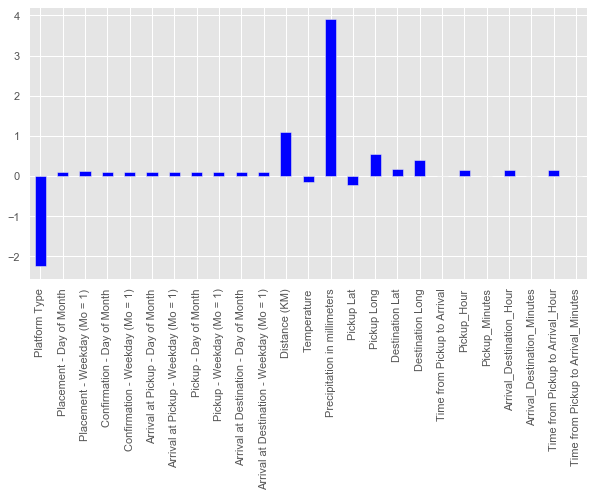

In [105]:
#Column Skewness of the testing dataset
train_df.skew().plot.bar(figsize =(10,5), color = 'Blue')
plt.show()

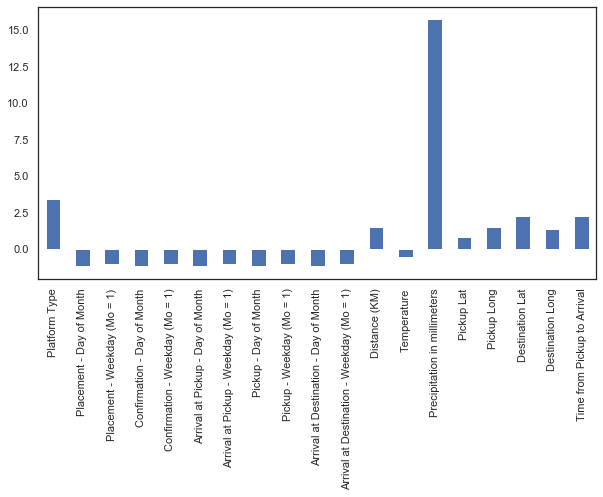

In [38]:
## Univariate Anaysis
# Calculating Skewness in the columns of our Training dataset
train_df.kurt().plot.bar(figsize =(10,5))
plt.show()

# Correlation

In [41]:
CorrMatrix_train = train_df.corr()
CorrMatrix_train.head()

,Platform Type,Placement - Day of Month,Placement - Weekday (Mo = 1),Confirmation - Day of Month,Confirmation - Weekday (Mo = 1),Arrival at Pickup - Day of Month,Arrival at Pickup - Weekday (Mo = 1),Pickup - Day of Month,Pickup - Weekday (Mo = 1),Arrival at Destination - Day of Month,Arrival at Destination - Weekday (Mo = 1),Distance (KM),Temperature,Precipitation in millimeters,Pickup Lat,Pickup Long,Destination Lat,Destination Long,Time from Pickup to Arrival
Platform Type,1.000000,0.012764,-0.058038,0.012770,-0.058005,0.012770,-0.058005,0.012770,-0.058005,0.012770,-0.058005,0.005528,0.225060,-0.055948,-0.002742,0.021327,0.006319,0.043924,-0.003827
Placement - Day of Month,0.012764,1.000000,0.026148,0.999998,0.026122,0.999998,0.026122,0.999998,0.026122,0.999998,0.026122,-0.007585,0.013097,-0.204143,-0.004929,-0.005453,0.007541,0.002077,-0.014710
Placement - Weekday (Mo = 1),-0.058038,0.026148,1.000000,0.026132,0.999952,0.026132,0.999952,0.026132,0.999952,0.026132,0.999952,0.003582,0.031064,-0.050592,-0.000918,0.011008,-0.004299,-0.000875,0.009693
Confirmation - Day of Month,0.012770,0.999998,0.026132,1.000000,0.026123,1.000000,0.026123,1.000000,0.026123,1.000000,0.026123,-0.007587,0.013099,-0.204143,-0.004923,-0.005448,0.007550,0.002073,-0.014701
Confirmation - Weekday (Mo = 1),-0.058005,0.026122,0.999952,0.026123,1.000000,0.026123,1.000000,0.026123,1.000000,0.026123,1.000000,0.003574,0.031074,-0.050592,-0.000883,0.011036,-0.004251,-0.000900,0.009744


In [42]:
CorrMatrix_test = test_df.corr()
CorrMatrix_train.head()

,Platform Type,Placement - Day of Month,Placement - Weekday (Mo = 1),Confirmation - Day of Month,Confirmation - Weekday (Mo = 1),Arrival at Pickup - Day of Month,Arrival at Pickup - Weekday (Mo = 1),Pickup - Day of Month,Pickup - Weekday (Mo = 1),Arrival at Destination - Day of Month,Arrival at Destination - Weekday (Mo = 1),Distance (KM),Temperature,Precipitation in millimeters,Pickup Lat,Pickup Long,Destination Lat,Destination Long,Time from Pickup to Arrival
Platform Type,1.000000,0.012764,-0.058038,0.012770,-0.058005,0.012770,-0.058005,0.012770,-0.058005,0.012770,-0.058005,0.005528,0.225060,-0.055948,-0.002742,0.021327,0.006319,0.043924,-0.003827
Placement - Day of Month,0.012764,1.000000,0.026148,0.999998,0.026122,0.999998,0.026122,0.999998,0.026122,0.999998,0.026122,-0.007585,0.013097,-0.204143,-0.004929,-0.005453,0.007541,0.002077,-0.014710
Placement - Weekday (Mo = 1),-0.058038,0.026148,1.000000,0.026132,0.999952,0.026132,0.999952,0.026132,0.999952,0.026132,0.999952,0.003582,0.031064,-0.050592,-0.000918,0.011008,-0.004299,-0.000875,0.009693
Confirmation - Day of Month,0.012770,0.999998,0.026132,1.000000,0.026123,1.000000,0.026123,1.000000,0.026123,1.000000,0.026123,-0.007587,0.013099,-0.204143,-0.004923,-0.005448,0.007550,0.002073,-0.014701
Confirmation - Weekday (Mo = 1),-0.058005,0.026122,0.999952,0.026123,1.000000,0.026123,1.000000,0.026123,1.000000,0.026123,1.000000,0.003574,0.031074,-0.050592,-0.000883,0.011036,-0.004251,-0.000900,0.009744


Text(0.5, 1.05, 'Train Dataset Pearson Correlation of Features')

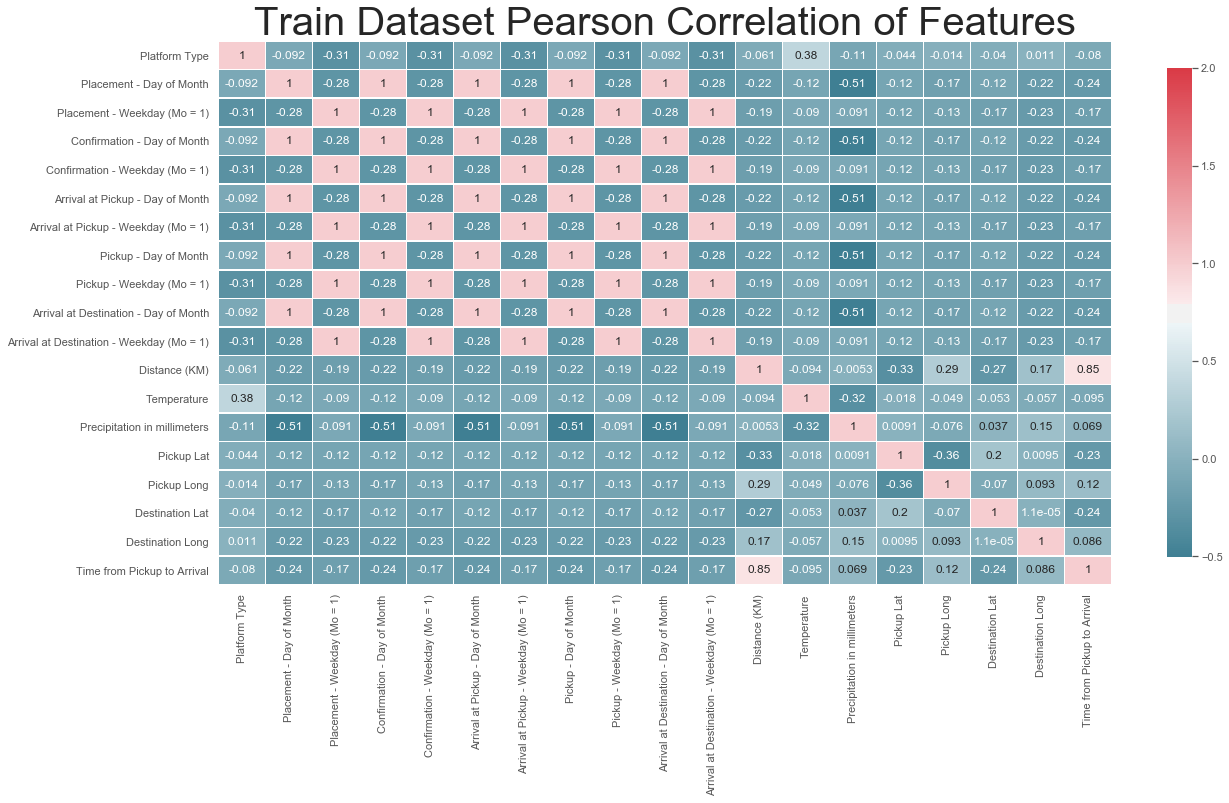

In [43]:
import matplotlib.style as style
style.use('ggplot')
cm = CorrMatrix_train.corr()
colormap = sns.diverging_palette(220, 10, as_cmap = True)
plt.figure(figsize=(20,10))
sns.heatmap(cm, annot=True, cmap = colormap,cbar_kws={'shrink':.9 },
           linewidths=0.5,vmax=2.0, linecolor='white',annot_kws={'fontsize':12 })
plt.title('Train Dataset Pearson Correlation of Features', y=1.05, size=40)

Text(0.5, 1.05, 'Test Dataset Pearson Correlation of Features')

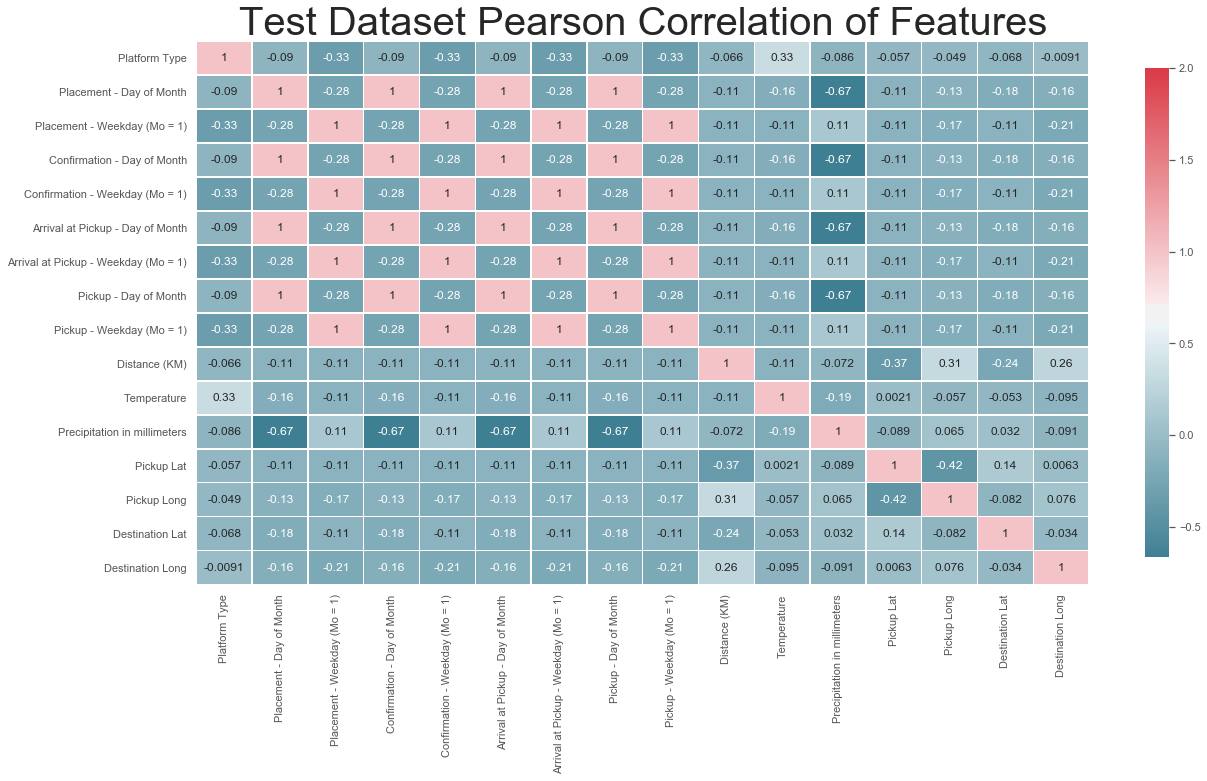

In [101]:
import matplotlib.style as style
style.use('ggplot')
cm = CorrMatrix_test.corr()
colormap = sns.diverging_palette(220, 10, as_cmap = True)
plt.figure(figsize=(20,10))
sns.heatmap(cm, annot=True, cmap = colormap,cbar_kws={'shrink':.9 },
           linewidths=0.5,vmax=2.0, linecolor='white',annot_kws={'fontsize':12 })
plt.title('Test Dataset Pearson Correlation of Features', y=1.05, size=40)

In [147]:
train_df["Pickup - Weekday (Mo = 1)"].unique()

array([5, 2, 1, 3, 4, 6, 7], dtype=int64)

In [106]:
test_df["Pickup - Weekday (Mo = 1)"].unique()

array([3, 5, 4, 1, 2, 6, 7], dtype=int64)

The company is running operation for 7 days a week.

In [111]:
train_df[train_df["Pickup - Weekday (Mo = 1)"]!=train_df["Arrival at Destination - Weekday (Mo = 1)"]]

,Order No,User Id,Vehicle Type,Platform Type,Personal or Business,Placement - Day of Month,Placement - Weekday (Mo = 1),Placement - Time,Confirmation - Day of Month,Confirmation - Weekday (Mo = 1),...,Destination Lat,Destination Long,Rider Id,Time from Pickup to Arrival,Pickup_Hour,Pickup_Minutes,Arrival_Destination_Hour,Arrival_Destination_Minutes,Time from Pickup to Arrival_Hour,Time from Pickup to Arrival_Minutes


All orders are delivered on the same day they are picked up, this is beacuse there are no orders where the day of the week of the pick-up is not the day of the week of the arrival.



In [80]:
train_df['Pickup - Time'] = pd.to_datetime(train_df['Pickup - Time'])
train_df['Arrival at Destination - Time'] = pd.to_datetime(train_df['Arrival at Destination - Time'])

Converting time format provided to datatime.

In [83]:
train_df['Pickup_Hour'] = train_df['Pickup - Time'].dt.hour
train_df['Arrival_Destination_Hour'] = train_df['Arrival at Destination - Time'].dt.hour
train_df['Time from Pickup to Arrival_Hour'] = train_df['Arrival at Destination - Time'].dt.hour

Converting the datatime to hours for more in depth time analysis.

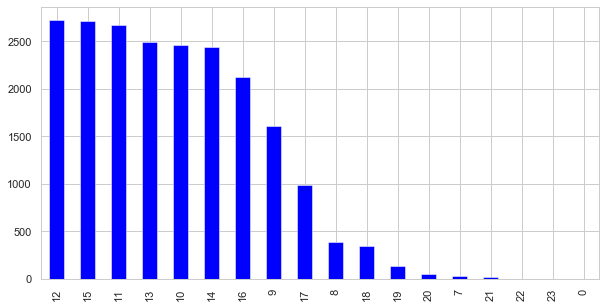

In [98]:
train_df['Pickup_Hour'].value_counts().plot(kind='bar',figsize=[10,5], color = 'blue')

Most of pickup hours are between 9 AM in the morning to 17 PM in the afternoon.


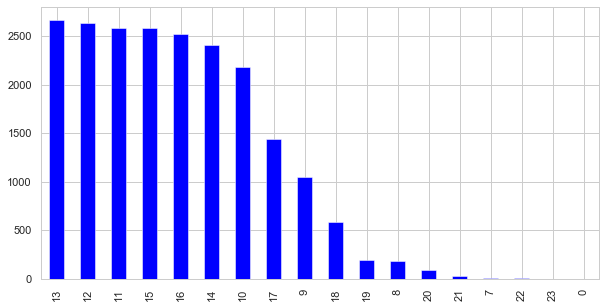

In [96]:
train_df['Arrival_Destination_Hour'].value_counts().plot(kind='bar',figsize=[10,5], color = 'Blue')

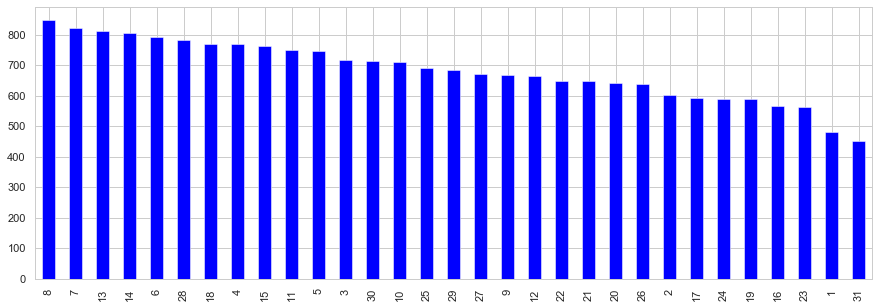

In [149]:
train_df['Arrival at Pickup - Day of Month'].value_counts().plot(kind='bar',figsize=[15,5], color = 'Blue')


In [ ]:
train_df['Arrival at Pickup - Day of Month'].value_counts().plot(kind='bar',figsize=[15,5], color = 'Blue')

Most of the Destination arrival hours are between 9 AM in the morning to 17 PM in the afternoon.

In [155]:
train_df['Pickup Lat'], train_df['Pickup Long']

(0       -1.317755
 1       -1.351453
 2       -1.308284
 3       -1.281301
 4       -1.266597
            ...   
 21196   -1.258414
 21197   -1.307143
 21198   -1.286018
 21199   -1.250030
 21200   -1.255189
 Name: Pickup Lat, Length: 21201, dtype: float64,
 0        36.830370
 1        36.899315
 2        36.843419
 3        36.832396
 4        36.792118
            ...    
 21196    36.804800
 21197    36.825009
 21198    36.897534
 21199    36.874167
 21200    36.782203
 Name: Pickup Long, Length: 21201, dtype: float64)

KeyError: "None of [Float64Index([-1.3177546999999998,           -1.351453,          -1.3082842,\n                       -1.2813012, -1.2665973999999998,          -1.3025826,\n                        -1.279395, -1.2527958000000001,          -1.2551895,\n                        -1.225322,\n              ...\n              -1.2821421999999998, -1.3167113000000001,          -1.2865677,\n                       -1.2602337,          -1.2384056,          -1.2584143,\n                        -1.307143,          -1.2860183, -1.2500303999999998,\n                       -1.2551895],\n             dtype='float64', length=21201)] are in the [columns]"

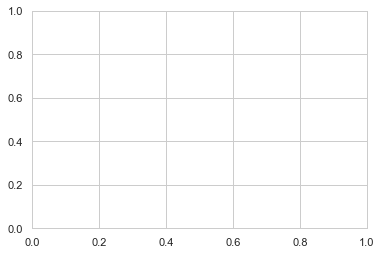

In [158]:
train_df.plot(kind="scatter", x= train_df['Pickup Lat'], y=train_df['Pickup Long'], alpha=0.1)
save_fig("better_visualization_plot")

The "Time from Pickup to Arrival" does not have any missing values.

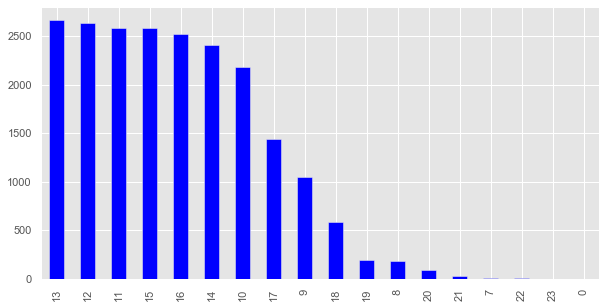

In [117]:
train_df['Time from Pickup to Arrival_Hour'].value_counts().plot(kind='bar',figsize=[10,5], color = 'blue')

Most of the Time from Pickup to Arrival_Hour are between 9 AM in the morning to 17 PM in the afternoon.

In [119]:
train_df['Time from Pickup to Arrival_Hour'].describe()

count    21201.000000
mean        13.303995
std          2.570458
min          0.000000
25%         11.000000
50%         13.000000
75%         15.000000
max         23.000000
Name: Time from Pickup to Arrival_Hour, dtype: float64

In [131]:
count = train_df['Time from Pickup to Arrival_Hour'].value_counts()
print(count)

13    2668
12    2636
11    2589
15    2586
16    2521
14    2411
10    2189
17    1445
9     1054
18     586
19     195
8      180
20      89
21      34
7        8
22       8
23       1
0        1
Name: Time from Pickup to Arrival_Hour, dtype: int64


The peak for Time from Pick to Arrival_hour is taking place at 13:00 PM in the afternoon and lowest at 00:00 AM in the early hours of the morning

### Match the number of train columns to the number of test columns and also separate the target variable

In [132]:
# save the columns from the test dataframe into a new list called testcols
testcols = test_df.columns

# reassign the number of the train dataframe to match that of the test by saving them to an updated dataframe, newtrain
train1 = train_df[testcols]

# Seperate the target variable from the predictor variable
y = np.array(train_df['Time from Pickup to Arrival']).reshape(-1, 1)

In [133]:
#Drop data not available in test, Pickup Time + label = Arrival times

train_df = train_df.drop(['Arrival at Destination - Day of Month', 'Arrival at Destination - Weekday (Mo = 1)', 'Arrival at Destination - Time'], axis=1)

In [ ]:
# print the new columns of the train and test data to show that they are the same
print(train1.columns)
print(test_df.columns)

# New Features

In [61]:
def time_of_day(hour):
    if (hour > 0) and (hour <= 12 ):
        return 'AM'
    else:
        return'PM'

In [62]:
time_of_day(14)

'PM'

## Distribution

In [64]:
Numeric_Training = train_df._get_numeric_data()
Numeric_Training.head()

,Platform Type,Placement - Day of Month,Placement - Weekday (Mo = 1),Confirmation - Day of Month,Confirmation - Weekday (Mo = 1),Arrival at Pickup - Day of Month,Arrival at Pickup - Weekday (Mo = 1),Pickup - Day of Month,Pickup - Weekday (Mo = 1),Arrival at Destination - Day of Month,...,Precipitation in millimeters,Pickup Lat,Pickup Long,Destination Lat,Destination Long,Time from Pickup to Arrival,Pickup_Hour,Pickup_Minutes,Arrival_Destination_Hour,Arrival_Destination_Minutes
0,3,9,5,9,5,9,5,9,5,9,...,NaN,-1.317755,36.830370,-1.300406,36.829741,745,10,27,10,39
1,3,12,5,12,5,12,5,12,5,12,...,NaN,-1.351453,36.899315,-1.295004,36.814358,1993,11,44,12,17
2,3,30,2,30,2,30,2,30,2,30,...,NaN,-1.308284,36.843419,-1.300921,36.828195,455,12,53,13,0
3,3,15,5,15,5,15,5,15,5,15,...,NaN,-1.281301,36.832396,-1.257147,36.795063,1341,9,43,10,5
4,1,13,1,13,1,13,1,13,1,13,...,NaN,-1.266597,36.792118,-1.295041,36.809817,1214,10,5,10,25


# Data Cleaning and Formatting

## Creating Full_df

In [137]:
#Create (full_df = train + test) ** caution (dont shuffle, avoid drop/adding rows)
#explore training, make (column) changes to full, later we use the border to separate
#Be careful of information leakage

border = train1.shape[0]
test_df['Time from Pickup to Arrival'] = [np.nan]* test_df.shape[0]
full_df = pd.concat([train1, test_df], axis=0, ignore_index=True)

train1.shape, test_df.shape, full_df.shape

((21201, 25), (7068, 26), (28269, 26))

### Renaming columns

In [138]:
#Renaming columns (shorten, remove space, standardize)
new_names = {"Order No": "Order_No", "User Id": "User_Id", "Vehicle Type": "Vehicle_Type",
    "Personal or Business": "Personal_Business", "Placement - Day of Month": "Pla_Mon",
    "Placement - Weekday (Mo = 1)": "Pla_Weekday", "Placement - Time": "Pla_Time", 
    "Confirmation - Day of Month":"Con_Day_Mon", "Confirmation - Weekday (Mo = 1)": "Con_Weekday","Confirmation - Time": "Con_Time", 
    "Arrival at Pickup - Day of Month": "Arr_Pic_Mon", "Arrival at Pickup - Weekday (Mo = 1)": "Arr_Pic_Weekday", 
                "Arrival at Pickup - Time": "Arr_Pic_Time", "Platform Type": "Platform_Type",
     "Pickup - Day of Month": "Pickup_Mon", "Pickup - Weekday (Mo = 1)": "Pickup_Weekday",           
    "Pickup - Time": "Pickup_Time",  "Distance (KM)": "Distance(km)",
    "Precipitation in millimeters": "Precipitation(mm)", "Pickup Lat": "Pickup_Lat", "Pickup Long": "Pickup_Lon", 
    "Destination Lat": "Destination_Lat", "Destination Long":"Destination_Lon", "Rider Id": "Rider_Id",
                            "Time from Pickup to Arrival": "Time_Pic_Arr"
                           }

full_df = full_df.rename(columns=new_names)
full_df.columns

Index(['Order_No', 'User_Id', 'Vehicle_Type', 'Platform_Type',
       'Personal_Business', 'Pla_Mon', 'Pla_Weekday', 'Pla_Time',
       'Con_Day_Mon', 'Con_Weekday', 'Con_Time', 'Arr_Pic_Mon',
       'Arr_Pic_Weekday', 'Arr_Pic_Time', 'Pickup_Mon', 'Pickup_Weekday',
       'Pickup_Time', 'Distance(km)', 'Temperature', 'Precipitation(mm)',
       'Pickup_Lat', 'Pickup_Lon', 'Destination_Lat', 'Destination_Lon',
       'Rider_Id', 'Time_Pic_Arr'],
      dtype='object')

### Convert Time

In [139]:
#Convert Time from 12H to 24H

def convert_to_24hrs(fulldf):
    for col in fulldf.columns:
        if col.endswith("Time"):
            fulldf[col] = pd.to_datetime(fulldf[col], format='%I:%M:%S %p').dt.strftime("%H:%M:%S")
    return fulldf

full_df = convert_to_24hrs(full_df)

full_df[['Pla_Time', 'Con_Time' , 'Arr_Pic_Time', 'Pickup_Time']][3:6]


ValueError: time data '2020-10-19 10:27:30' does not match format '%I:%M:%S %p' (match)

### Filling Missing Values

In [141]:
#Filling Missing Values for temperatures and humidity

full_df['Temperature'] = full_df['Temperature'].fillna(full_df['Temperature'].mean())
full_df['Precipitation(mm)'].fillna(full_df['Precipitation(mm)'].mean(), inplace=True)

In [142]:
full_df.head()

,Order_No,User_Id,Vehicle_Type,Platform_Type,Personal_Business,Pla_Mon,Pla_Weekday,Pla_Time,Con_Day_Mon,Con_Weekday,...,Pickup_Time,Distance(km),Temperature,Precipitation(mm),Pickup_Lat,Pickup_Lon,Destination_Lat,Destination_Lon,Rider_Id,Time_Pic_Arr
0,Order_No_4211,User_Id_633,Bike,3,Business,9,5,09:35:46,9,5,...,2020-10-19 10:27:30,4,20.400000,7.573502,-1.317755,36.830370,-1.300406,36.829741,Rider_Id_432,NaN
1,Order_No_25375,User_Id_2285,Bike,3,Personal,12,5,11:16:16,12,5,...,2020-10-19 11:44:09,16,26.400000,7.573502,-1.351453,36.899315,-1.295004,36.814358,Rider_Id_856,NaN
2,Order_No_1899,User_Id_265,Bike,3,Business,30,2,12:39:25,30,2,...,2020-10-19 12:53:03,3,23.255689,7.573502,-1.308284,36.843419,-1.300921,36.828195,Rider_Id_155,NaN
3,Order_No_9336,User_Id_1402,Bike,3,Business,15,5,09:25:34,15,5,...,2020-10-19 09:43:06,9,19.200000,7.573502,-1.281301,36.832396,-1.257147,36.795063,Rider_Id_855,NaN
4,Order_No_27883,User_Id_1737,Bike,1,Personal,13,1,09:55:18,13,1,...,2020-10-19 10:05:23,9,15.400000,7.573502,-1.266597,36.792118,-1.295041,36.809817,Rider_Id_770,NaN


### Traversing Month and Weekday

In [143]:
#Since, we have not been given the actual dates & bikes (same day) were used, is Pick, Arrival date not the same?

month_cols = [col for col in full_df.columns if col.endswith("Mon")]
weekday_cols = [col for col in full_df.columns if col.endswith("Weekday")]

count = 0
instances_of_different_days = [];
for i, row in full_df.iterrows():
    if len(set(row[month_cols].values)) > 1:
        print(count+1, end="\r")
        count = count + 1
        instances_of_different_days.append(list(row[month_cols].values))
instances_of_different_days

[[17, 18, 18, 18], [11, 13, 13, 13]]

In [144]:
month_cols

['Pla_Mon', 'Con_Day_Mon', 'Arr_Pic_Mon', 'Pickup_Mon']

In [145]:
weekday_cols

['Pla_Weekday', 'Con_Weekday', 'Arr_Pic_Weekday', 'Pickup_Weekday']

### Creating Month and Weekday columns

In [146]:
full_df['Day_of_Month'] = full_df[month_cols[0]]
full_df['Day_of_Week'] = full_df[weekday_cols[0]]

### Dropping redundant columns

In [ ]:
#All Vehicle types are Bikes, Vehicle Type is not necessary.
#Day & Weekday values are repeated in all rows except 2, we retain only one
full_df.drop(month_cols+weekday_cols, axis=1, inplace=True)
full_df.drop('Vehicle_Type', axis=1, inplace=True)

full_df.head(3)

In [135]:
full_df.head()

NameError: name 'full_df' is not defined

In [ ]:
full_df.columns

### Variable Datatypes

In [150]:
numeric_cols = []
object_cols = []
time_cols = []
for k, v in full_df.dtypes.items():
    if (v != object):
        if (k != "Time_Pic_Arr"):
            numeric_cols.append(k)
    elif k.endswith("Time"):
        time_cols.append(k)
    else:
        object_cols.append(k)

In [151]:
full_df[numeric_cols].head()

,Platform_Type,Pla_Mon,Pla_Weekday,Con_Day_Mon,Con_Weekday,Arr_Pic_Mon,Arr_Pic_Weekday,Pickup_Mon,Pickup_Weekday,Distance(km),Temperature,Precipitation(mm),Pickup_Lat,Pickup_Lon,Destination_Lat,Destination_Lon,Day_of_Month,Day_of_Week
0,3,9,5,9,5,9,5,9,5,4,20.400000,7.573502,-1.317755,36.830370,-1.300406,36.829741,9,5
1,3,12,5,12,5,12,5,12,5,16,26.400000,7.573502,-1.351453,36.899315,-1.295004,36.814358,12,5
2,3,30,2,30,2,30,2,30,2,3,23.255689,7.573502,-1.308284,36.843419,-1.300921,36.828195,30,2
3,3,15,5,15,5,15,5,15,5,9,19.200000,7.573502,-1.281301,36.832396,-1.257147,36.795063,15,5
4,1,13,1,13,1,13,1,13,1,9,15.400000,7.573502,-1.266597,36.792118,-1.295041,36.809817,13,1


In [152]:
full_df[time_cols].head()

,Pla_Time,Con_Time,Arr_Pic_Time,Pickup_Time
0,09:35:46,09:40:10,10:04:47,2020-10-19 10:27:30
1,11:16:16,11:23:21,11:40:22,2020-10-19 11:44:09
2,12:39:25,12:42:44,12:49:34,2020-10-19 12:53:03
3,09:25:34,09:26:05,09:37:56,2020-10-19 09:43:06
4,09:55:18,09:56:18,10:03:53,2020-10-19 10:05:23


In [153]:
full_df[object_cols].head()

,Order_No,User_Id,Vehicle_Type,Personal_Business,Rider_Id
0,Order_No_4211,User_Id_633,Bike,Business,Rider_Id_432
1,Order_No_25375,User_Id_2285,Bike,Personal,Rider_Id_856
2,Order_No_1899,User_Id_265,Bike,Business,Rider_Id_155
3,Order_No_9336,User_Id_1402,Bike,Business,Rider_Id_855
4,Order_No_27883,User_Id_1737,Bike,Personal,Rider_Id_770


### Convert object types to numeric

In [ ]:
#Convert an object to numeric (encoding)

le = LabelEncoder()
le.fit(full_df['Personal_Business'])
full_df['Personal_Business'] = le.transform(full_df['Personal_Business'])
full_df['Personal_Business'][:2]


In [ ]:
full_df.head()

# Feature Engineering

### Feature Selection

In [ ]:
features = numeric_cols + ['Personal_Business']

data_df = full_df[features]

y = full_df[:border]['Time_Pic_Arr']
train = data_df[:border]
test = data_df[border:]

train.head()

In [ ]:
print(full_df.shape,data_df.shape,train.shape,test.shape,y.shape)

In [ ]:
train

In [ ]:
test

In [ ]:
y

# Train/Test split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train, y, test_size=0.2, shuffle=True)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# Modeling

### Cross validation

In [ ]:
rs = 3
kfold = KFold(n_splits=10, random_state=rs, shuffle=True)

regressors = []
regressors.append(SVR())
regressors.append(GradientBoostingRegressor(random_state=rs))
regressors.append(ExtraTreesRegressor(n_estimators=rs))
regressors.append(RandomForestRegressor(random_state=rs))
#regressors.append(xgb.XGBRegressor(random_state=rs, objective="reg:squarederror"))
regressors.append(lgb.LGBMRegressor(random_state=rs))

cv_results = []
for regressor in regressors:     #scores to be minimised are negated (neg)
    cv_results.append(np.sqrt(abs(cross_val_score(regressor, X_train, y=y_train, scoring='neg_mean_squared_error', cv=kfold))))

cv_means = []
cv_stds = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_stds.append(cv_result.std())
    
#cv_res = pd.DataFrame({ 
#    "Algorithm": ["SVR", "GBR", "EXR", "RFR", "XGBR", "LGBM"],
#    "CrossValMeans": cv_means, "CrossValErrors": cv_stds
#                       })
cv_res = pd.DataFrame({ 
    "Algorithm": ["SVR", "GBR", "EXR", "RFR", "LGBM"],
    "CrossValMeans": cv_means, "CrossValErrors": cv_stds
                       })

cv_res = cv_res.sort_values("CrossValMeans", ascending=True)
print(cv_res)

# Making predictions

## Random Forest

In [ ]:
RFC = RandomForestRegressor(random_state=rs)
rf_param = {"max_depth":[None], "max_features":[3], "min_samples_split":[10],
           "min_samples_leaf": [3], "n_estimators":[300]}
rsearch = GridSearchCV(RFC, cv=kfold, scoring='neg_mean_squared_error',param_grid=rf_param)
rfm = rsearch.fit(X_train, y_train)

r_score = np.sqrt(abs(rfm.best_score_))
r_params = rfm.best_p
arams_
print(r_score, r_params)

In [ ]:
Prediction = predict(fit, test)
submit = data.frame(PassengerId = test$PassengerId, Survived = Prediction)
write.csv(submit, file = “firstforest.csv”, row.names = FALSE)

In [ ]:
lgbm_y = lgbm.predict(test, num_iteration=lgbm.best_iteration)
lgbm_output = pd.DataFrame({"Order No":test_df['Order No'], 
                           "Time from Pickup to Arrival": lgbm_y })
lgbm_output.to_csv("submission.csv", index=False)

In [ ]:
y_pred = lr.predict(test_new)

In [ ]:
submission_df = test_df1[['Order No']]
submission_df['Time_Pic_Arr'] = y_pred

In [ ]:
#submission_df.to_csv('D:/Temp/LRImproved.csv', index = False)

## Lightgbm

### Parameter Tuning

In [ ]:
params = {
    'n_estimators':[75], # [75, 95],
    'num_leaves': [15], #[12,15, 17],
    'reg_alpha': [0.02], #[0.02, 0.05],
    'min_data_in_leaf': [300],  #[250, 280, 300]
    'learning_rate': [0.1], #[0.05, 0.1, 0.25],
    'objective': ['regression'] #['regression', None]
    }

lsearch = GridSearchCV(estimator = lgb.LGBMRegressor(random_state=rs), cv=kfold,scoring='neg_mean_squared_error', param_grid=params)
lgbm = lsearch.fit(X_train, y_train)

l_params = lgbm.best_params_
l_score = np.sqrt(abs(lgbm.best_score_))
print(lgbm.best_params_, np.sqrt(abs(lgbm.best_score_)))

## Training and making a prediction

In [ ]:
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

lparams = {
           'learning_rate': 0.1, 'min_data_in_leaf': 300, 
           'n_estimators': 75, 'num_leaves': 20, 'random_state':rs,
           'objective': 'regression', 'reg_alpha': 0.02,
          'feature_fraction': 0.9, 'bagging_fraction':0.9}


lgbm = lgb.train(lparams, lgb_train, valid_sets=lgb_eval, num_boost_round=20, early_stopping_rounds=20)

lpred = lgbm.predict(X_test, num_iteration=lgbm.best_iteration)

print("The RMSE of prediction is ", mean_squared_error(y_test, lpred)**0.5)


# Submission

In [ ]:
lgbm_y = lgbm.predict(test, num_iteration=lgbm.best_iteration)
lgbm_output = pd.DataFrame({"Order No":test_df['Order No'], 
                           "Time from Pickup to Arrival": lgbm_y })
lgbm_output.to_csv("D:\Temp\submission.csv", index=False)